In [127]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Load  and preview data
sample_submission = pd.read_csv("sample_submission.csv.gz")
train = pd.read_csv("train.csv.gz")
test = pd.read_csv("test.csv.gz")

print(train.describe())
print(train.head())

AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A705357    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824  
  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN  

Data Cleaning

In [128]:
# Change name variable to binary feature detecting if there's a name or not

def binarize_name(df):
    df = df.rename(columns={'Name': 'HasName'})
    df['HasName'] = pd.to_numeric(df['HasName'].str.isalpha())
    df['HasName'] = df['HasName'].fillna(0)
    return df

train = binarize_name(train)
test = binarize_name(test)

# Fill NA for SexuponOutcome with 'Unknown'
train['SexuponOutcome'] = train['SexuponOutcome'].fillna('Unknown')
test['SexuponOutcome'] = test['SexuponOutcome'].fillna('Unknown')

# Fill NA for AgeuponOutcome with temporary placeholder, later we will impute the average after the data is formatted
train = train.fillna({'AgeuponOutcome': '9999 days'})
test = test.fillna({'AgeuponOutcome': '9999 days'})

# convert 'AgeuponOutcome' to days
def string_to_num_days(series):
    # split string into column for quantity and  time unit
    split_series = series.str.split(" ")
    split_df = pd.DataFrame(split_series.to_list(), columns=['multiplier', 'days'])

    convert_days = {'year': 365, 'years': 365, 'months': 30.5, 'month': 30.5, 'week': 7, 'weeks': 7, 'days': 1, 'day':1}
    split_df['days'] = split_df['days'].map(convert_days)
    
    # multiply the two columns to get the age in number of days
    split_df['multiplier'] = split_df['multiplier'].astype(int)
    split_df['total_days'] = split_df['days'] * split_df['multiplier']

    return split_df['total_days']

train['AgeuponOutcome'] = string_to_num_days(train['AgeuponOutcome'])
test['AgeuponOutcome'] = string_to_num_days(test['AgeuponOutcome'])

In [129]:
# Fill the placeholders for NA with the column average
train = train.replace({'AgeuponOutcome': {9999: np.nan}})
train['AgeuponOutcome'] = train['AgeuponOutcome'].fillna(train['AgeuponOutcome'].mean())

test = test.replace({'AgeuponOutcome': {9999: np.nan}})
test['AgeuponOutcome'] = test['AgeuponOutcome'].fillna(test['AgeuponOutcome'].mean())



In [130]:
# Extract animal color
def extract_color(df):
    df['IsSolidColor'] = 1
    mixed_entries = df['Color'].str.contains(r'\/')
    df.loc[mixed_entries, 'IsSolidColor'] = 0          # if multiple colors are detected, set IsSolidColor to 0
    df['Color'] = df['Color'].str.replace('\/.*', '')  # only use the first color
    return df

train = extract_color(train)
test = extract_color(test)

# Extract other color markings
def extract_markings(df):
    for marking in ['Tabby','Point','Tiger','Brindle','Smoke','Tick','Merle']:
        df[marking] = df['Color'].str.contains(marking).astype(int)

    return df
    
train = extract_markings(train)
test = extract_markings(test)

In [131]:
# Extract mixed breeds
def extract_purebred(df):
    df['Purebred'] = 1
    mixed_entries = (df['Breed'].str.contains('\/')) | (df['Breed'].str.contains('Mix'))
    df.loc[mixed_entries, 'Purebred'] = 0
    return df

train = extract_purebred(train)
test = extract_purebred(test)

# Extract aggressive breeds
def extract_aggression(df):
    aggro_breeds = 'Staffordshire|Pit|Doberman|Chow|Rottweiler|German Shepherd|American Bulldog|Mastiff|Bullmastiff|Husky|Malamute|Akita|Boxer'
    df['AggroBreed'] = 0
    df.loc[df['Breed'].str.contains(aggro_breeds), 'AggroBreed'] = 1
    return df

train = extract_aggression(train)
test = extract_aggression(test)

# Extract Hypoallergenic breeds
def extract_hypoallergenic(df):
    hypoallergenic_breeds = 'Affenpinscher|Afghan|Hairless|Barbet|Bedlington|Bichon|Bolognese|Crested|Schnauzer|Water Spaniel|Kerry|Maltese|Poodle|Portuguese Water|Yorkshire'
    df['HypoallergenicBreed'] = 0
    df.loc[df['Breed'].str.contains(hypoallergenic_breeds), 'HypoallergenicBreed'] = 1
    return df

train = extract_hypoallergenic(train)
test = extract_hypoallergenic(test)

In [132]:
# Convert time to useable format
train['DateTime'] = pd.to_datetime(train['DateTime'], infer_datetime_format=True)
test['DateTime'] = pd.to_datetime(test['DateTime'], infer_datetime_format=True)

# Round time of day to nearest hour
train['Hour'] = train['DateTime'].dt.round("H").dt.hour
test['Hour'] = test['DateTime'].dt.round("H").dt.hour

# Encode 'hour' in two dimensions to account for cyclical nature
train['HourSin'] = np.sin(2 * np.pi * train['Hour']/23.0)
train['HourCos'] = np.cos(2 * np.pi * train['Hour']/23.0)

test['HourSin'] = np.sin(2 * np.pi * test['Hour']/23.0)
test['HourCos'] = np.cos(2 * np.pi * test['Hour']/23.0)

# Add day of the week column
train['DayOfWeek'] = pd.to_datetime(train['DateTime'], infer_datetime_format=True).dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})
test['DayOfWeek'] = pd.to_datetime(test['DateTime'], infer_datetime_format=True).dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})


In [133]:
# Extract dog or cat
train['Dog'] = train['AnimalType'].str.contains('Dog').astype(int)
test['Dog'] = test['AnimalType'].str.contains('Dog').astype(int)

# divide SexuponOutcome into two features
def extract_sex_info(df):
    df['SexuponOutcome'].dropna(inplace=True)
    df['Male'] = df['SexuponOutcome'].str.contains("Male").astype(int)
    df['Intact'] = df['SexuponOutcome'].str.contains("Intact").astype(int)
    df['SexUnknown'] = df['SexuponOutcome'].str.contains("Unknown").astype(int)
    return df

train = extract_sex_info(train)
test = extract_sex_info(test)
    

Data Exploration

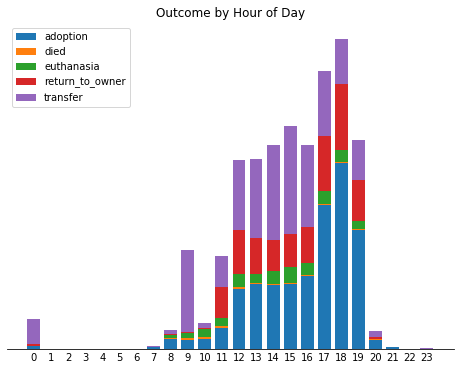

In [171]:
# Plot outcome by time of day

hourly_outcomes = train.groupby('Hour')['OutcomeType'].value_counts().unstack(0)
hourly_outcomes = hourly_outcomes.fillna(0)

fig, ax = plt.subplots(figsize=(8, 6))

ind = hourly_outcomes.columns
width = .75

adoption = hourly_outcomes.loc['Adoption'].values
died = hourly_outcomes.loc['Died'].values
euthanasia = hourly_outcomes.loc['Euthanasia'].values
return_to_owner = hourly_outcomes.loc['Return_to_owner'].values
transfer = hourly_outcomes.loc['Transfer'].values

ax.bar(ind, adoption, width)
ax.bar(ind, died, width, bottom = adoption)
ax.bar(ind, euthanasia, width, bottom = adoption + died)
ax.bar(ind, return_to_owner, width, bottom = adoption + died + euthanasia)
ax.bar(ind, transfer, width, bottom = adoption + died + euthanasia +return_to_owner)
ax.legend(['adoption','died','euthanasia','return_to_owner','transfer'])
ax.set_title("Outcome by Hour of Day")

plt.xticks(range(24), ('0', '1', '2', '3', '4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_yticks([]) 
for x in ['top','left','right']:
    ax.spines[x].set_visible(False)

plt.show()

# We see unusual activity around 9 and midnight. In the data there are many timestamps set to 9:00:00 and 00:00:00.
# With this in mind, it may be helpful to include a 'OnTheHour' feature that is triggered if the time is X:00:00
# When training the model we will use the 'HourSin' and 'HourCos' features which capture the cyclical nature

The plot shows some unusual activity at 9a and midnight. Outcomes with this timestamp are very likely to be transfers. After examining the data, we see there are many timestamps with exact times of 9:00:00 and 00:00:00

In [212]:
print(train[train['DateTime'].dt.hour == 0][['DateTime', 'OutcomeType']].head())
#print(train[train['DateTime'].dt.time == '09:00:00'][['DateTime', 'OutcomeType']])


DateTime OutcomeType
38  2015-08-11    Transfer
117 2015-11-05    Transfer
175 2015-09-01    Transfer
181 2015-12-22    Transfer
195 2015-09-01    Transfer


In [201]:
print(train[train['Hour'] == 0][['DateTime', 'OutcomeType']])


DateTime      OutcomeType
38    2015-08-11         Transfer
117   2015-11-05         Transfer
175   2015-09-01         Transfer
181   2015-12-22         Transfer
195   2015-09-01         Transfer
248   2015-08-05  Return_to_owner
251   2016-02-07         Transfer
289   2015-11-05         Transfer
306   2015-11-23         Transfer
409   2015-11-24         Transfer
627   2016-02-07         Transfer
644   2015-05-31         Transfer
696   2015-11-24         Transfer
769   2015-07-02         Transfer
798   2015-08-11         Transfer
816   2016-01-31         Transfer
832   2016-02-15         Transfer
896   2015-05-17         Transfer
1039  2015-10-17         Adoption
1084  2015-11-17         Transfer
1087  2015-11-10         Transfer
1172  2015-10-16         Transfer
1213  2015-07-02         Transfer
1295  2015-04-10         Transfer
1313  2016-01-22  Return_to_owner
1406  2015-05-31         Transfer
1411  2015-11-08         Adoption
1551  2016-01-05         Transfer
1640  2015-08-23      

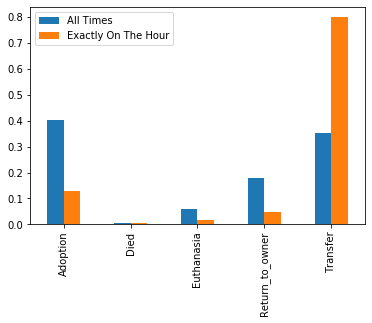

In [136]:
# Add 'OnTheHour' variable that tracks whether the time is exactly on the hour
train['OnTheHour'] = (train['DateTime'].dt.minute == 0) & (train['DateTime'].dt.second == 0).astype(int)
test['OnTheHour'] = (test['DateTime'].dt.minute == 0) & (test['DateTime'].dt.second == 0).astype(int)

all_times = train['OutcomeType'].value_counts(normalize=True)
on_the_hour = train[train['OnTheHour']==1]['OutcomeType'].value_counts(normalize=True)
comparison = pd.concat([all_times, on_the_hour], axis=1)
comparison.columns = ['All Times', 'Exactly On The Hour']

comparison.plot.bar()

We see significant differences in the cases that are recorded on X:00:00, which should be good for our model's predictive power.


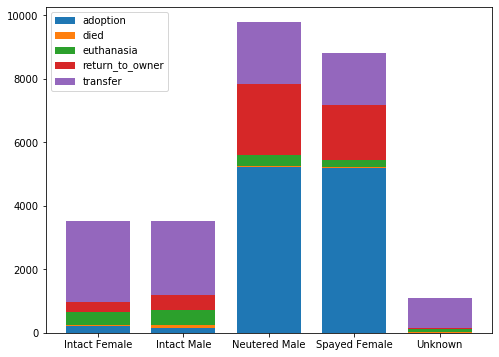

Index(['Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female',
       'Unknown'],
      dtype='object', name='SexuponOutcome')


In [137]:
sex_outcomes = train.groupby('SexuponOutcome')['OutcomeType'].value_counts().unstack(0)
sex_outcomes = sex_outcomes.fillna(0)

fig, ax = plt.subplots(figsize=(8, 6))

ind = sex_outcomes.columns
width = .75

adoption = sex_outcomes.loc['Adoption'].values
died = sex_outcomes.loc['Died'].values
euthanasia = sex_outcomes.loc['Euthanasia'].values
return_to_owner = sex_outcomes.loc['Return_to_owner'].values
transfer = sex_outcomes.loc['Transfer'].values

ax.bar(ind, adoption, width)
ax.bar(ind, died, width, bottom = adoption)
ax.bar(ind, euthanasia, width, bottom = adoption + died)
ax.bar(ind, return_to_owner, width, bottom = adoption + died + euthanasia)
ax.bar(ind, transfer, width, bottom = adoption + died + euthanasia + return_to_owner)

ax.legend(['adoption','died','euthanasia','return_to_owner','transfer'])
plt.xticks(range(5), ('Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown'))
plt.show()
print(sex_outcomes.columns)

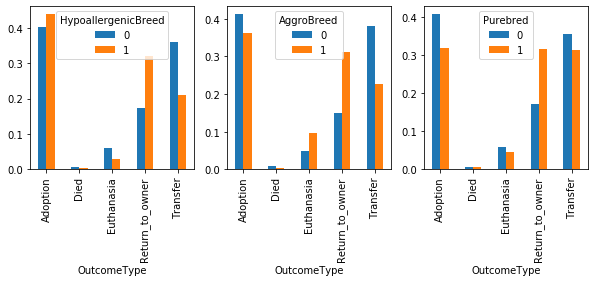

In [138]:
# Now we explore different breed attributes
# again we have normalized the results to isolate the relative impact of the features
fig, axis = plt.subplots(1,3, figsize=(10,3))

train.groupby('HypoallergenicBreed')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.bar(ax=axis[0])
train.groupby('AggroBreed')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.bar(ax=axis[1])
train.groupby('Purebred')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.bar(ax=axis[2])

plt.show()

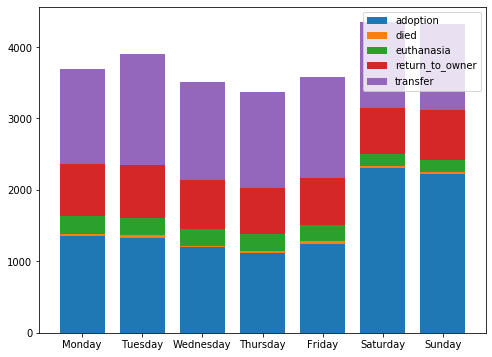

DayOfWeek        Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
OutcomeType                                                               
Adoption           1353     1330       1194      1119    1248      2308   
Died                 27       32         26        20      31        29   
Euthanasia          257      246        231       250     235       163   
Return_to_owner     722      736        689       641     648       652   
Transfer           1337     1552       1370      1346    1424      1196   

DayOfWeek        Sunday  
OutcomeType              
Adoption           2217  
Died                 32  
Euthanasia          173  
Return_to_owner     698  
Transfer           1197  


In [139]:
day_outcomes = train.groupby('DayOfWeek')['OutcomeType'].value_counts().unstack(0)
day_outcomes = day_outcomes.fillna(0)

# Fix column order
day_outcomes = day_outcomes[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

fig, ax = plt.subplots(figsize=(8, 6))

ind = day_outcomes.columns
width = .75

adoption = day_outcomes.loc['Adoption'].values
died = day_outcomes.loc['Died'].values
euthanasia = day_outcomes.loc['Euthanasia'].values
return_to_owner = day_outcomes.loc['Return_to_owner'].values
transfer = day_outcomes.loc['Transfer'].values

ax.bar(ind, adoption, width)
ax.bar(ind, died, width, bottom = adoption)
ax.bar(ind, euthanasia, width, bottom = died + adoption)
ax.bar(ind, return_to_owner, width, bottom = died + adoption + euthanasia)
ax.bar(ind, transfer, width, bottom = died + adoption + euthanasia + return_to_owner)
ax.legend(['adoption','died','euthanasia','return_to_owner','transfer'])
plt.xticks(range(7), ('Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.show()
print(day_outcomes)

In [140]:
#We see most of the day_of_week variation occurs between weekdays and weekends, so our model will probably do better by reducing cardinality to weekend or weekday.


In [141]:
# Extract weekend variable from DateTime
def is_weekend(df):
    df['weekend'] = df['DateTime'].dt.weekday.isin([5, 6]).astype(int)
    df = df.drop(columns=['DayOfWeek'])
    return df

train = is_weekend(train)
test = is_weekend(test)

In [ ]:
# Here we explore outcomes based on whether it is a weekend or not. The data is normalized rather than using the raw sum. We see Adoption is much more likely to occur on weekends.
# train.groupby('weekend')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.bar()


In [142]:
# plt.hist(train[train['OutcomeType']=='Adoption']['AgeuponOutcome'],bins=5, range=(train['AgeuponOutcome'].min(), train['AgeuponOutcome'].max()))

In [143]:
# trying to plot age grouped bar plot with bins, not going well

# n_bins = 8

# fig, axes = plt.subplots(nrows=2, ncols=2)
# ax0, ax1, ax2, ax3 = axes.flatten()

# colors = ['red', 'tan', 'lime']
# ax0.hist(x, n_bins, histtype='bar', color=colors, label=colors)
# ax0.legend(prop={'size': 10})
# ax0.set_title('bars with legend')

# ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
# ax1.set_title('stacked bar')

# ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
# ax2.set_title('stack step (unfilled)')

# # Make a multiple-histogram of data-sets with different length.
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
# ax3.hist(x_multi, n_bins, histtype='bar')
# ax3.set_title('different sample sizes')

# fig.tight_layout()
# plt.show()

In [144]:
# No fucking idea why I have to do this a 2nd time
train = train.dropna(subset=['AgeuponOutcome'])
test = test.dropna(subset=['AgeuponOutcome'])

In [145]:
# Feature selection
# After looking at feature importance, we have gone back to remove the variables related to markings as they appear to be unhelpful

y_train = train['OutcomeType']

X_train = train[['HasName','AgeuponOutcome','Purebred', 'AggroBreed', 'HypoallergenicBreed','HourSin', 'HourCos', 'OnTheHour', 'Dog', 'Male', 'Intact',
       'SexUnknown', 'weekend']]
X_train = pd.get_dummies(X_train)

X_test = test[['HasName','AgeuponOutcome','Purebred', 'AggroBreed', 'HypoallergenicBreed','HourSin', 'HourCos', 'OnTheHour', 'Dog', 'Male', 'Intact',
       'SexUnknown', 'weekend']]

X_test = pd.get_dummies(X_test)


In [146]:
print(y_train)

0        Return_to_owner
1             Euthanasia
2               Adoption
3               Transfer
4               Transfer
5               Transfer
6               Transfer
7               Transfer
8               Adoption
9               Adoption
10              Transfer
11              Adoption
12              Adoption
13       Return_to_owner
14       Return_to_owner
15              Adoption
16              Transfer
17              Transfer
18              Transfer
19       Return_to_owner
20              Transfer
21              Transfer
22              Adoption
23              Adoption
24       Return_to_owner
25              Transfer
26              Adoption
27              Adoption
28              Adoption
29       Return_to_owner
              ...       
26699         Euthanasia
26700    Return_to_owner
26701           Transfer
26702               Died
26703           Transfer
26704           Transfer
26705           Transfer
26706           Adoption
26707         Euthanasia


In [147]:

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [148]:
# from sklearn.tree import DecisionTreeClassifier

# # Instantiate classifier
# clf = DecisionTreeClassifier()

# # Train model on training data
# clf.fit(X_train, y_train)

# # Make predictions
# pred = clf.predict_proba(X_valid)

# print(clf.classes_)
# print(pred)
# print(y_valid)

In [149]:
# # Make predictions on test set
# test_pred = clf.predict_proba(X_test)

# len(test_pred)

In [150]:


# Random forest model
rf = RandomForestClassifier(n_estimators = 500)

# train model
rf.fit(X_train, y_train)

# make predictions
pred = rf.predict_proba(X_valid)

# check accuracy
# TO DO

In [151]:
# Train model on whole data set
full_X_train = pd.concat([X_train, X_valid], axis = 0)
full_y_train = pd.concat([y_train, y_valid], axis = 0)

rf.fit(full_X_train, full_y_train)

# make final predictions
final_pred = rf.predict_proba(X_test)

In [152]:
# results = pd.DataFrame(final_pred, columns = rf.classes_, index = test['ID']).reset_index()
# results.to_csv('submission.csv', index=False)

In [153]:
# from sklearn.svm import LinearSVC
# # Instantiate model with 1000 decision trees
# svc_model = LinearSVC(random_state=6)

# # Train the model on training data
# svc_model.fit(X_train, y_train)

# # Predictions
# predictions = svc_model.predict(X_valid)

In [154]:
#pd.DataFrame({'pred': predictions, 'y_valid': y_valid})

In [155]:


# Define the model
xgb_model = XGBClassifier(random_state = 0, 
                         n_estimators = 500, 
                         learning_rate = .05)

# Fit the model
xgb_model.fit(full_X_train, full_y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

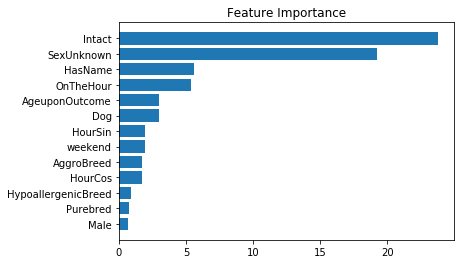

In [159]:
# Inspect feature importance
feature_importance = xgb_model.get_booster().get_score(importance_type="gain")

feature_importance = sorted(feature_importance.items(), key=lambda x: x[1])

feature = list(zip(*feature_importance))[0]
score = list(zip(*feature_importance))[1]
y_pos = np.arange(len(feature)) 

plt.barh(y_pos, score, align='center')
plt.yticks(y_pos, feature) 
plt.title('Feature Importance')
plt.show()

In [157]:
# Get predictions
xgb_pred = xgb_model.predict_proba(X_test) 

In [158]:
results = pd.DataFrame(xgb_pred, columns = rf.classes_, index = test['ID']).reset_index()
results.to_csv('submission.csv', index=False)